In [ ]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Anish Pahilajani"
STUDENT_ID = "1726777"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

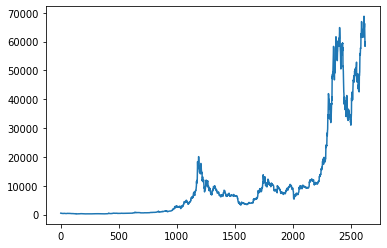

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

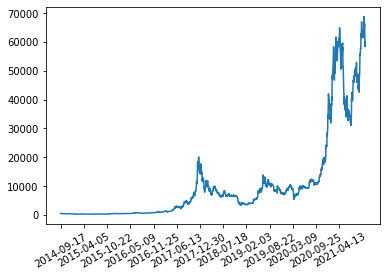

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [ ]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = data["High"]### YOUR CODE HERE ###

Remove missing values from the data.

In [ ]:
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)

data_high = data_high.dropna()### YOUR CODE HERE ###
print(data_high.shape)

(2618,)



Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [ ]:
### YOUR CODE HERE ###
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))### YOUR CODE HERE ###
data_high = data_high.to_numpy(np.float32)
data_normalized = scaler.fit_transform(data_high.reshape((-1, 1)))### YOUR CODE HERE ###
data_normalized = data_normalized.reshape(-1,)

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [ ]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
time_steps = 15 ### YOUR CODE HERE ###

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
X, y = create_dataset(data_normalized, time_steps)

In [ ]:
# Check the shape of your dataset; should be (2618-time_steps-1, time_steps) and (2618-time_steps-1,)
print(X.shape, y.shape)

(2602, 15) (2602,)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [ ]:
### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = False)

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [ ]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# The shape of the training and test data after this step should be ((2618-time_steps-1) * 80%, 1, time_steps) and ((2618-time_steps-1) * 20%, 1, time_steps), respectively.
X_train.shape

(2081, 1, 15)

In [ ]:
X_test.shape

(521, 1, 15)

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [ ]:
# Build your model
from keras.models import Sequential
from keras.layers import *
model = Sequential()
# HELP
# 50 is the number of LSTM neurons, each will have its own time unrollment
# time_steps represent how many time steps each data entry contains, in this case its 10
# input_shape is the shape of imput data which is a single vector
model.add(LSTM(50, input_shape=(1, time_steps))) 
model.add(Dense(1))
### YOUR CODE HERE ###

loss = 'mean_squared_error' ### YOUR CODE HERE ###

opt = 'adam'### YOUR CODE HERE ###

metrics = ['mean_squared_error']### YOUR CODE HERE ###

model.compile(loss = loss, 
              optimizer = opt, metrics = metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                13200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batchsize = 128### YOUR CODE HERE ###

epochs =  20### YOUR CODE HERE ###

# Fit model - Use 20% validation split
history = model.fit(X_train, y_train, validation_split=0.2, epochs = epochs, batch_size = batchsize)### YOUR CODE HERE ###

Epoch 1/20
13/13 [==============================] - 7s 41ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 9.3035e-04 - mean_squared_error: 9.3035e-04 - val_loss: 2.6189e-04 - val_mean_squared_error: 2.6189e-04
Epoch 3/20
13/13 [==============================] - 0s 5ms/step - loss: 2.9423e-04 - mean_squared_error: 2.9423e-04 - val_loss: 3.1218e-04 - val_mean_squared_error: 3.1218e-04
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 1.1383e-04 - mean_squared_error: 1.1383e-04 - val_loss: 1.4787e-04 - val_mean_squared_error: 1.4787e-04
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 9.8916e-05 - mean_squared_error: 9.8916e-05 - val_loss: 1.4871e-04 - val_mean_squared_error: 1.4871e-04
Epoch 6/20
13/13 [==============================] - 0s 5ms/step - loss: 9.3765e-05 - mean_squared_error: 9.3765e-05 - val_loss: 1.4093e

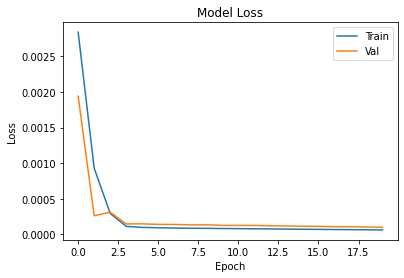

In [ ]:
# Plot the model loss
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

### YOUR CODE HERE ###
plot_losses(history)

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###
model = Sequential()
model.add(LSTM(50, input_shape=(1, time_steps)))
model.add(Dense(300))
model.add(Dropout(0.3))
model.add(Dense(200))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dense(1))

loss = 'mean_squared_error'### YOUR CODE HERE ###

opt = 'adam'### YOUR CODE HERE ###

metrics = ['mean_squared_error']### YOUR CODE HERE ###

model.compile(loss = loss, 
              optimizer = opt, metrics = metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                13200     
                                                                 
 dense_1 (Dense)             (None, 300)               15300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               60200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
batchsize = 600### YOUR CODE HERE ###
epochs =  10### YOUR CODE HERE ###

# Fit model
history =  model.fit(X_train, y_train, validation_split=0.2, epochs = epochs, batch_size = batchsize)### YOUR CODE HERE ###

Epoch 1/10
3/3 [==============================] - 2s 233ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 1.7744e-04 - val_mean_squared_error: 1.7744e-04
Epoch 2/10
3/3 [==============================] - 0s 18ms/step - loss: 5.7708e-04 - mean_squared_error: 5.7708e-04 - val_loss: 5.6818e-04 - val_mean_squared_error: 5.6818e-04
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 5.0133e-04 - mean_squared_error: 5.0133e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
3/3 [==============================] - 0s 14ms/step - loss: 5.2326e-04 - mean_squared_error: 5.2326e-04 - val_loss: 1.6556e-04 - val_mean_squared_error: 1.6556e-04
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 2.3909e-04 - mean_squared_error: 2.3909e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/10
3/3 [==============================] - 0s 17ms/step - loss: 3.1566e-04 - mean_squared_error: 3.1566e-04 - val_loss: 2.2283e-04 - val_mean

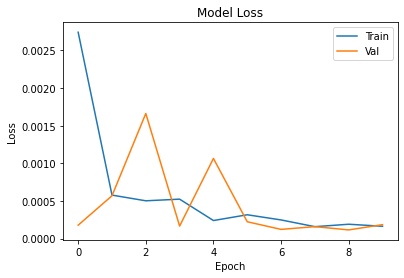

In [ ]:
# Plot the model loss
### YOUR CODE HERE ###
plot_losses(history)

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

17/17 [==============================] - 0s 2ms/step


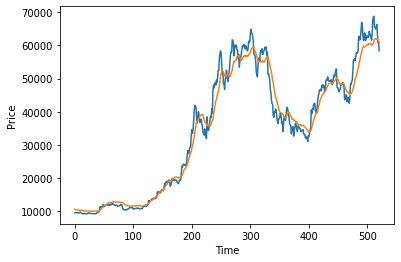

In [ ]:
### YOUR CODE HERE ###
testY = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(testY)
plt.ylabel('Price')
plt.xlabel('Time')

pred = model.predict(X_test)
plt.plot(scaler.inverse_transform(pred))
plt.show()

### Answer:
The model improves with having deeper fully connected neural netowork, and there is a slight improvement when increasing the number of look back days.

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import textwrap
from tensorflow.keras.layers import *
# Load data

### YOUR CODE HERE ###
max_sequence_len = 200 #2376 
(x_train, y_train), (_, _) = tf.keras.datasets.reuters.load_data(maxlen=max_sequence_len, test_split=0)#, seed = 139)
# print("TOTAL LENGTH OF DATA: ", len(x_train))
# Clean and pre-process the data

### YOUR CODE HERE ###
word_dict = tf.keras.datasets.reuters.get_word_index()
# for i in range(50):
#   for key, value in word_dict.items(): 
#     if value == i:
#         print('(', key, ',', value, ')', sep = '', end = ',')

word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

#print(word_dict)

vocab_size = len(word_dict.keys())
# print('Number of words in vocabulary: ', vocab_size)
# for i in range(50):
#   for key, value in word_dict.items(): 
#     if value == i:
#         print('(', key, ',', value, ')', sep = '', end = ',')

inverse_word_dict = {value:key for key,value in word_dict.items()}
#print(inverse_word_dict)

# Print sample data

def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

### YOUR CODE HERE ###
x_train = pad_sequences(x_train, maxlen=max_sequence_len)
print("\n")
for i in range(5):
    print(decode_review(x_train[i], inverse_word_dict), end='\n')
    print('Label: ', y_train[i])
    print('\n\n')


2110848/2110848 [==============================] - 0s 0us/step


<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?


550378/550378 [==============================] - 0s 0us/step


<START> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987
of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs
from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per
share this year should be 2 50 to three dlrs reuter 3
Label:  3



<START> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in
factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the
transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3
Label:  4



<START> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln
year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 

<ipython-input-25-949b3110fbde>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word is '' or word is '\n':
<ipython-input-25-949b3110fbde>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word is '' or word is '\n':


### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, stratify= y_train)

### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 128)(input_layer)
x = LSTM(64)(x) 
x = Dense(46, activation='softmax')(x)

reuters_model = Model(input_layer, x)

loss = tf.keras.losses.SparseCategoricalCrossentropy()### YOUR CODE HERE ###

opt = 'adam'### YOUR CODE HERE ###

metrics = ['accuracy']### YOUR CODE HERE ###

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          3965824   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 46)                2990      
                                                                 
Total params: 4,018,222
Trainable params: 4,018,222
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batchsize = 128### YOUR CODE HERE ###
epochs =  10### YOUR CODE HERE ###

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10
45/45 [==============================] - 3s 28ms/step - loss: 2.8629 - accuracy: 0.3913 - val_loss: 2.2457 - val_accuracy: 0.4209
Epoch 2/10
45/45 [==============================] - 1s 16ms/step - loss: 2.1572 - accuracy: 0.4111 - val_loss: 2.2261 - val_accuracy: 0.4216
Epoch 3/10
45/45 [==============================] - 1s 16ms/step - loss: 2.0188 - accuracy: 0.5071 - val_loss: 1.8814 - val_accuracy: 0.5607
Epoch 4/10
45/45 [==============================] - 1s 16ms/step - loss: 1.7237 - accuracy: 0.5894 - val_loss: 1.6540 - val_accuracy: 0.5784
Epoch 5/10
45/45 [==============================] - 1s 16ms/step - loss: 1.4839 - accuracy: 0.6247 - val_loss: 1.4788 - val_accuracy: 0.6363
Epoch 6/10
45/45 [==============================] - 1s 16ms/step - loss: 1.3268 - accuracy: 0.6659 - val_loss: 1.4489 - val_accuracy: 0.6490
Epoch 7/10
45/45 [==============================] - 1s 16ms/step - loss: 1.1887 - accuracy: 0.7088 - val_loss: 1.4056 - val_accuracy: 0.6582
Epoch 8/10
45

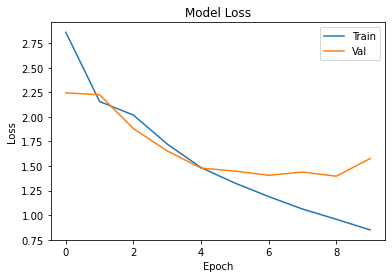

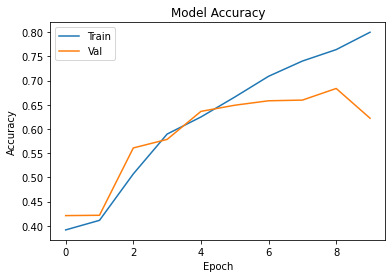

In [ ]:
# Plot the model loss and accuracy on training and validation sets
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
### YOUR CODE HERE ###
plot_losses(history)
plot_accuracies(history)

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 128)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
# x = Bidirectional(LSTM(32, return_sequences=True))(x)
# x = Bidirectional(LSTM(32))(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(64, activation='relu')(x)
x = Dense(46, activation='softmax')(x)

model = Model(input_layer, x)

loss = tf.keras.losses.SparseCategoricalCrossentropy() ### YOUR CODE HERE ###

opt = tf.keras.optimizers.Adam()### YOUR CODE HERE ###

metrics = ['accuracy']### YOUR CODE HERE ###

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          3965824   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 46)                5934      
                                                                 
Total params: 4,169,390
Trainable params: 4,169,390
Non-tra

In [ ]:
batchsize = 32### YOUR CODE HERE ###
epochs = 15 ### YOUR CODE HERE ###

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/15
177/177 [==============================] - 14s 41ms/step - loss: 1.8378 - accuracy: 0.5470 - val_loss: 1.5881 - val_accuracy: 0.5996
Epoch 2/15
177/177 [==============================] - 6s 34ms/step - loss: 1.4370 - accuracy: 0.6389 - val_loss: 1.5293 - val_accuracy: 0.6285
Epoch 3/15
177/177 [==============================] - 10s 55ms/step - loss: 1.4032 - accuracy: 0.6456 - val_loss: 1.5591 - val_accuracy: 0.6236
Epoch 4/15
177/177 [==============================] - 10s 54ms/step - loss: 1.2629 - accuracy: 0.6915 - val_loss: 1.4388 - val_accuracy: 0.6617
Epoch 5/15
177/177 [==============================] - 7s 37ms/step - loss: 1.1105 - accuracy: 0.7288 - val_loss: 1.3904 - val_accuracy: 0.6702
Epoch 6/15
177/177 [==============================] - 6s 34ms/step - loss: 0.9582 - accuracy: 0.7652 - val_loss: 1.4320 - val_accuracy: 0.6589
Epoch 7/15
177/177 [==============================] - 6s 34ms/step - loss: 0.8418 - accuracy: 0.7878 - val_loss: 1.3872 - val_accuracy: 0.6

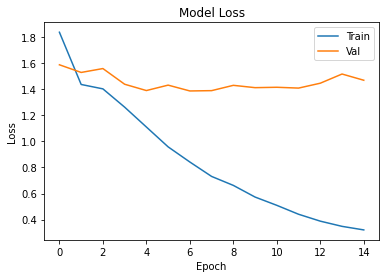

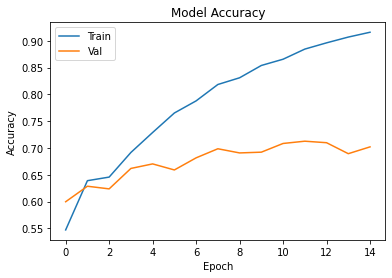

In [ ]:
# Plot the model loss and accuracy

### YOUR CODE HERE ###
plot_losses(history)
plot_accuracies(history)

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [ ]:
### YOUR CODE HERE ###
teslLoss, testAccuracy = model.evaluate(X_test, y_test)
print("Accuracy: ", testAccuracy)
y_pred = model.predict(X_test)


yy_pred = [np.argmax(i) for i in y_pred]
yy_pred = np.asarray(yy_pred)
d = {}
for i in range(len(yy_pred)):
    if y_test[i] not in d.keys():
        d[y_test[i]] = [1,0]
    else:
        d[y_test[i]][0]+=1
    if yy_pred[i] == y_test[i]:
        d[y_test[i]][1]+=1

print("\n\n")
for i in range(46):
    print(f"Accuracy for label {i} =  {(d[i][1]/d[i][0])*100}%")

56/56 [==============================] - 1s 14ms/step - loss: 1.5259 - accuracy: 0.6870
Accuracy:  0.6870056390762329
56/56 [==============================] - 2s 13ms/step



Accuracy for label 0 =  14.285714285714285%
Accuracy for label 1 =  66.23376623376623%
Accuracy for label 2 =  7.6923076923076925%
Accuracy for label 3 =  88.78248974008208%
Accuracy for label 4 =  76.86567164179104%
Accuracy for label 5 =  0.0%
Accuracy for label 6 =  40.0%
Accuracy for label 7 =  66.66666666666666%
Accuracy for label 8 =  46.15384615384615%
Accuracy for label 9 =  25.0%
Accuracy for label 10 =  39.130434782608695%
Accuracy for label 11 =  44.44444444444444%
Accuracy for label 12 =  0.0%
Accuracy for label 13 =  33.33333333333333%
Accuracy for label 14 =  20.0%
Accuracy for label 15 =  0.0%
Accuracy for label 16 =  30.158730158730158%
Accuracy for label 17 =  0.0%
Accuracy for label 18 =  21.428571428571427%
Accuracy for label 19 =  63.829787234042556%
Accuracy for label 20 =  47.82608695652174%
